<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [3]:
#@title Current Date
Today = '2021-09-06' #@param {type:"date"}


In [4]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "8908079" #@param {type:"string"}
Student_full_name = "Morgan Lynch" #@param {type:"string"}
#@markdown ---

In [5]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# Introduction
This notebook aims to process handwriting samples from the MNIST database into their correct classifications. It uses two methods to do this, firstly it uses logistic regression to classify the images and secondly it uses Bayesian multinomial regression to classify the images.



## Dataset
The dataset being used is the MNIST database of handwriting samples. This database includes ten classes representing the numbers zero to nine. Each of the images in the database is 28x28 giving 784 pixels per image.

After initially loading the data it is downsampled by selecting 3 classes randomly. From these classes 5,000 instances were randomly selected from each. Then 20% of the initial training data was set aside for testing.

The dataset is very evenly distributed so the only pre-processing required was to normalize the inputs by bringing them into the 0 to 1 range (divide by 255).

## Method
After the data was normalised and downsampled into 3 random classes it was then split into training and test data.
For the test data 20% was held back.

Using the training data a logistic regression model was created. The accuracy of this model was then measured ay 97%.

Following this a probabilistic multinomial logistic regression model was then trained which in turn produced an accuracy of 98%.
This approach was carried out using PyMC3 library.

Using the posterior uncertainty, the data was sorted by difficulty of classification. The most difficult 5% of this data was then removed and the logistic regression re-run.

This produced an improved accuracy of 100%. 

# Coding
 

## Import Libraries

In [6]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
#from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [8]:
# Setting a seed:
np.random.seed(123)

## Load the MNIST dataset

In [9]:
#Check if running on colab, use local path if not
from IPython import get_ipython
RunningInCOLAB = 'google.colab' in str(get_ipython())
Path = "mnist/"
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    Path = "/content/drive/MyDrive/ULProjects/etivity1/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#Generic function to output shape and histogram of data inputs
def check_data(data, label, n_classes=0, show_hist=False, hist_title="Histogram"):
    print(label+": "+str(data.shape))
    if show_hist==True:
        fig, ax = plt.subplots()
        ind = np.arange(n_classes)
        #n, bins, patches = ax.hist(data, n_classes)
        n, bins, patches = ax.hist(data, ec='black', align='mid')
        ax.set_xlabel('classes')
        ax.set_ylabel('counts')
        ax.set_title(hist_title)
        plt.show()


In [11]:
# MNIST Data
train_data = Path + "mnist_train.csv"
test_data = Path + "mnist_test.csv"

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values #df_train.iloc[: , 1:] #
y_train = df_train.label.values #df_train.iloc[:, 0] #
check_data(X_train,"X_train")
check_data(y_train,"y_train")


# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values #df_test.iloc[: , 1:] #
y_test = df_test.label.values #df_test.iloc[:, 0] #
check_data(X_test,"X_test")
check_data(y_test,"y_test")

X_train: (60000, 784)
y_train: (60000,)
X_test: (10000, 784)
y_test: (10000,)


### Normalize the data

Normalize the data to be within the 0 to 1 range

In [12]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


## Check and describe the data

In [13]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution
Check the distribution of classes within the data.

y_train: (60000,)


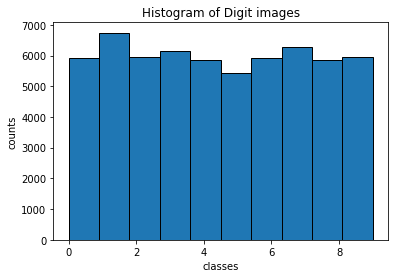

In [14]:

#Output shape and histogram using generic function
check_data(y_train, "y_train", n_classes, True, "Histogram of Digit images")

The distrubution appears to be very even between the classes.

## Data Processing

The data will be downsampled to make it easier to process.

### Randomly select 3 of the 10 Digit Classes

In [15]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes


[1, 2, 6]

### Randomly select instances from the 3 classes

X_train: (15000, 784)
y_train: (15000,)


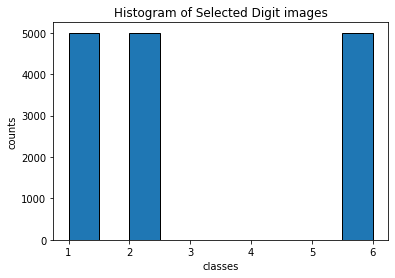

In [16]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000

inputs = []
labels=[]
# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    #print(imgs.shape)
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

#Output shapes using generic function
check_data(X_train,"X_train")
check_data(y_train, "y_train", n_classes, True, "Histogram of Selected Digit images")

Histogram shows the three selected classes with an equal amount of data in each.

### Check and describe the selected classes/instances

In [17]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Original Images')

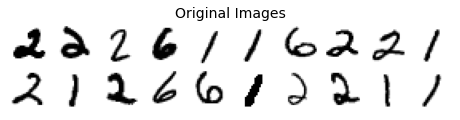

In [18]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices=[1,3,5,7,10]

#Randomly select a number of indices to show
random_indices = []
for i in range(20):
    random_indices.append(random.randint(0, len(X_train))-1)

# Plotting 'original' image
plot_digits(X_train[random_indices],images_per_row=10)
plt.title("Original Images", fontsize=14)

The randomly selected images appear quite legible and clear. There is however a lot of variation in the shapes visible within each class.

### Split the Training data into both Training and Validation Sets:

The data will be split into training/test samples. In this case we will reserve 20% of the data for testing.

In [19]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [20]:
# print shape of your validation and training set
check_data(X_train,"X_train")
check_data(y_train,"y_train")
check_data(X_val,"X_val")
check_data(y_val,"y_val")



X_train: (12000, 784)
y_train: (12000,)
X_val: (3000, 784)
y_val: (3000,)


## Logistic Regression

Train a general recipe machine learning algorithm on our dataset. The model will be trained and then validated against the previously set aside test data.

### General-Recipe ML

In [21]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val) 
#output predicted classifications
print("Predicted Classifications: "+ str(y_pred_log))

# probability to be in each class
y_pred_log_prob = model_log.predict_proba(X_val)
#Maximum probability
prob_classmax = np.max(y_pred_log_prob,axis=1)



Predicted Classifications: [1. 6. 6. ... 6. 2. 1.]


### Results of Logistic Regression


In [22]:
# output probabilities
print(y_pred_log_prob)
print("prob_classmax: "+ str(prob_classmax))

# Computing the Accuracy:
print("Accuracy=", accuracy_score(y_pred_log,y_val))

#Output probability where prediction is not equal to actual
print("Incorrect Classifications: "+ str(prob_classmax[y_pred_log!=y_val]))
print(f"Count of Misclassifications {len(prob_classmax[y_pred_log!=y_val])}")

[[9.89319288e-01 1.06807116e-02 4.76138495e-12]
 [8.22258447e-31 1.94781453e-09 9.99999998e-01]
 [1.08484577e-18 2.96789897e-08 9.99999970e-01]
 ...
 [4.59976424e-27 1.12232890e-12 1.00000000e+00]
 [2.80274723e-26 1.00000000e+00 1.89379916e-28]
 [9.99999944e-01 5.59197806e-08 1.32127806e-14]]
prob_classmax: [0.98931929 1.         0.99999997 ... 1.         1.         0.99999994]
Accuracy= 0.974
Incorrect Classifications: [1.         0.99999077 0.9999588  0.99981346 0.98077742 0.93171042
 0.87101809 0.97074899 0.99999997 0.5127126  0.92704799 0.99916064
 0.68539843 0.99888431 1.         0.58881459 0.93712818 0.99980607
 0.92442708 0.86345933 0.99999999 0.75001607 0.99999971 0.99946898
 0.99999839 0.98467197 0.99772392 0.99996546 0.99977153 0.89015917
 0.8553116  0.74902851 0.96660222 0.97656528 0.67239852 0.63622645
 0.95333169 0.96560912 0.96013932 1.         0.99699723 0.99951713
 0.97159038 0.63273573 0.99833885 0.98800242 0.95570851 0.97790471
 0.68067795 0.99953662 0.93555316 0.9999

The overall accuracy with logistic regression was quite high at 97% but still with 78 misclassifications

## Probabilistic Multinomial Logistic Regression
For this type of regression we must convert the training output to a binary list where the position of the positive value indicates the class.

A random selection of features and classes are used to define alpha and beta.

### Encoding the Class labels for the Probabilistic ML Model

In [23]:
import sklearn.preprocessing
#Reshape the data into binary lists
y_train2 = y_train.reshape(-1,1)
#print(y_train2)
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train2)
#print(y_2_bin)

In [24]:
y_2_bin

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

The classifications are now binary encoded

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [25]:
#Get the number of input features
nf = X_train.shape[1]
print(nf)
# Get the number of classes
nc = len(classes)

784


In [26]:

# get the float type
floatX = tt.config.floatX
init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

### Fit the training data. 
Fit the data and use this to generate the posterior distribution

In [27]:
#number of posterior samples
psamples=30000
#fit
with multi_logistic:
    approx = pm.fit(psamples, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 6,991.3


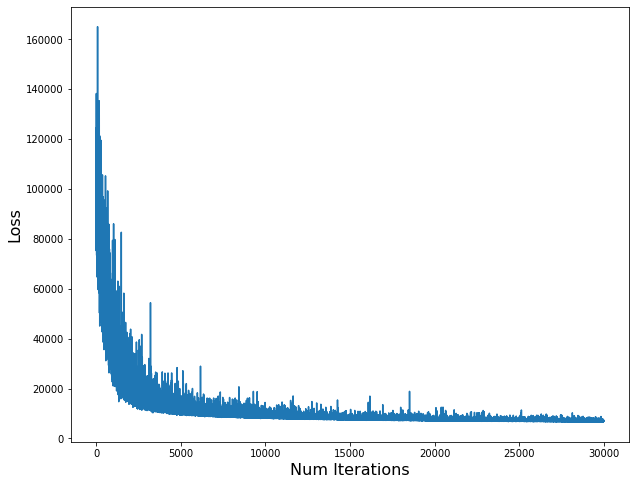

In [28]:
plt.figure(figsize=(10,8))
plt.xlabel('Num Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(approx.hist)
plt.show()

The above histogram shows the gradually decreasing loss with each iteration.

Draw samples from the model as our posterior. Generate a plot of the posterior data:

arviz - WARNING - Shape validation failed: input_shape: (1, 300), minimum_shape: (chains=2, draws=4)


mean    sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta[0,0]    0.34  8.80  -16.94    15.63  ...     0.39    283.42    194.58    NaN
beta[0,1]   -0.07  7.74  -14.72    14.76  ...     0.37    229.62    288.02    NaN
beta[1,0]    0.74  8.68  -14.29    17.91  ...     0.33    343.33    287.63    NaN
beta[1,1]   -1.57  8.84  -19.29    13.68  ...     0.36    290.93    283.47    NaN
beta[2,0]   -2.27  9.05  -18.18    14.02  ...     0.37    310.82    293.71    NaN
...           ...   ...     ...      ...  ...      ...       ...       ...    ...
beta[782,1] -2.01  8.52  -18.53    12.77  ...     0.39    246.01    332.34    NaN
beta[783,0]  0.84  8.72  -15.73    18.00  ...     0.36    298.06    235.67    NaN
beta[783,1] -0.05  8.68  -13.58    18.88  ...     0.36    319.85    290.76    NaN
alpha[0]     0.25  0.28   -0.27     0.75  ...     0.01    333.72    225.52    NaN
alpha[1]    -1.27  0.33   -1.89    -0.69  ...     0.01    339.50    247.27    NaN

[1570 rows x 9 columns]

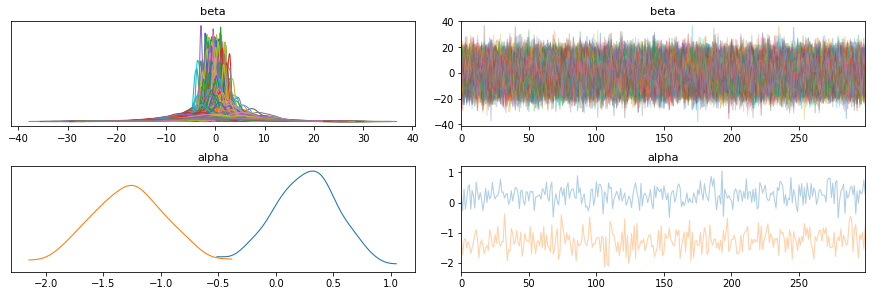

In [30]:
dd = 300
posterior = approx.sample(draws=dd)
az.plot_trace(posterior);
display(az.summary(posterior, round_to=2))

The right column in the charts above shows samples from the Markhov chain in sequential order.

test image #3
posterior sample #10
true class= 1.0
classes: [1, 2, 6]
estimated prob= [0.99886074 0.00113839 0.00000086]


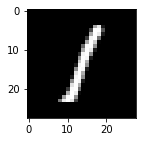

In [31]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 3 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 10 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [32]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

print(f"Accuracy of Bayesian Model: {accuracy_score(np.array(classes)[y_pred_Bayesian], y_val):.4f}")

Accuracy of Bayesian Model: 0.9817


In [33]:
#Selecting different instances
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [34]:
# prediction array
mm = 10
y_predB[0:mm,:]

#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.50497701, 0.49998889],
       [2.        , 0.50369347, 0.49995555],
       [1.        , 0.51588749, 0.49959984],
       [2.        , 0.52579608, 0.49928838],
       [2.        , 0.52284853, 0.49928838],
       [0.        , 0.44937654, 0.49888765],
       [2.        , 0.5445219 , 0.49839743],
       [1.        , 0.53886283, 0.49839743],
       [1.        , 0.54882761, 0.49811868],
       [1.        , 0.55897629, 0.49811868]])

In [35]:
#Count the number of incorrect classifications
len (y_predB[y_pred_log != y_val,:])

78

In [36]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.66


There is a significant difference in the accuracy of easy versus difficult instances.

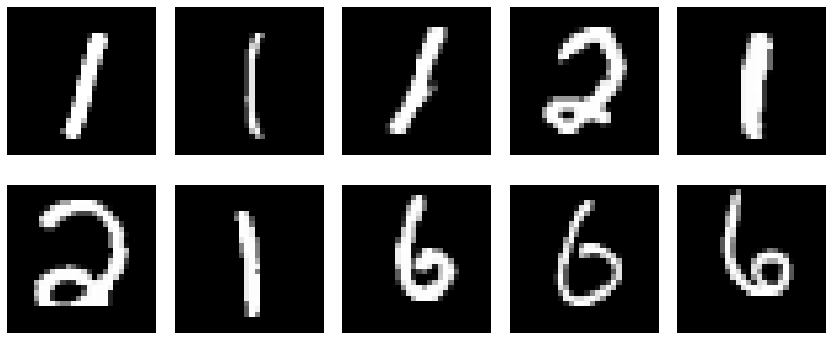

In [37]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

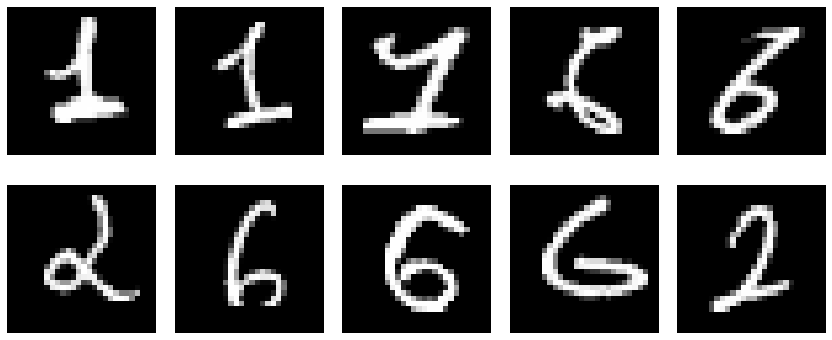

In [38]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

## Retrain general model with most difficult 5% removed

We will try again after removing the most difficult 5% - 250 instances

In [39]:
#remove the difficult instances
X_val = np.delete(X_val, difficult[0:250], axis=0)
y_val = np.delete(y_val, difficult[0:250], axis=0)

In [40]:
#reset and retrain
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_val, y_val)
y_pred_log = model_log.predict(X_val) 
print("Accuracy=", accuracy_score(y_pred_log,y_val))



Accuracy= 1.0


# Summary

In this Etivity both logistic regression and probabilistic multinomial regression were used to build models to classify the images from the MNIST database.

The initial data was loaded and three classes were selected at random. From within these classes 5000 instances were selected from each.

For the logistic regression the model was able to predict the class with approv 97% accuracy. For the probabilistic regression an accuracy rate of 98% was achieved.

The data was then sorted by the most and least difficult to classify. By removing the 250 (5%) most difficult to classify the accuracy rate was increased to 100%. 

Overall all three approached produced good results, but by identifying and removing the most difficult instances the ideal accuracy of 100% was achieved. 

It is likely that this approach could be improved upon further by including all of the dataset not just a subset. It is possible that performance could be improved further by refining the number of difficult instances to remove. 

# References
Salvatier, J., Wiecki, T., Fonnesbeck, C. Getting started with pymc3¶. Getting started with PyMC3 - PyMC3 3.10.0 documentation. Available at: https://docs.pymc.io/notebooks/getting_started.html

In [46]:
#Export PDF file
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ET5003_Etivity1_MorganLynch_8908079.ipynb')